#### Resources:
- Paul Centore - A Zonohedral Approach to Optimal Colours
(https://legacy.sites.fas.harvard.edu/~cs278/papers/zone.pdf)
- Jessica Lee - Theory of Human Tetrachromatic Color Experience and Printing (https://imjal.github.io/theory-of-tetrachromacy/static/pdfs/Lee_TheoryofTet_v1.pdf)

#### Instructions:
Make sure to install Jessica's repository as a Python package using the line below. It requires Python 3.11.

In [1]:
!pip install -q git+https://github.com/VarunNSrivastava/ChromaLab

In [2]:
from chromalab.observer import Observer
from chromalab.spectra import Spectra, Illuminant
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
import matplotlib.animation as animation
import pandas as pd
%matplotlib widget

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm

class ObjectColorSolidAlpha2:
    def __init__(self, observer, illuminant, wavelengths, alpha='Q'):
        self.rgbcmf = self.loadciergb(wavelengths)  # CIEXYZ RGB color matching functions
        self.observer = observer  # Observer instance from tetrachromat
        self.illuminant = illuminant  # Illuminant instance
        self.wavelengths = wavelengths  # Wavelengths for the responses
        self.alpha = alpha  # Alpha value or method for transparency
        
        # Use cone responses in SMQL order
        self.coneresponses = np.vstack((
            self.observer.sensors[3].data,  # L-cone
            self.observer.sensors[1].data,  # M-cone
            self.observer.sensors[0].data,  # S-cone
            self.observer.sensors[2].data   # Q-cone
        ))  # Shape: (4, n)

        self.numreceptors = self.coneresponses.shape[0]
        self.vertices = self.computeVertexBuffer()  # Shape: (n + 1, n, 4)
        self.faces, self.facecolors = self.computeFacesAndColorsBuffer()  # Faces and colors for visualization

    def computeFacesAndColorsBuffer(self):
        n = len(self.wavelengths)
        num_faces = n * (n - 1)  # Total number of faces
        faces = np.zeros((num_faces, 4, 3))  # Shape for 3D vertices (not 4D)
        face_colors = np.zeros((num_faces, 4))  # RGBA colors

        face_index = 0  # Global face index
        for i in tqdm(range(1, n)):
            for j in range(n):
                # Define face vertices (take only first 3 dimensions) 0, 1, 3
                faces[face_index, 0] = self.vertices[i, j, :3]
                faces[face_index, 1] = self.vertices[i - 1, (j + 1) % n, :3]
                faces[face_index, 2] = self.vertices[i, (j + 1) % n, :3]
                faces[face_index, 3] = self.vertices[i + 1, j, :3]

                # Reflectance placeholder
                reflectance = np.zeros(n)
                for k in range(i):
                    reflectance[(j + k) % n] = 1

                # Compute RGB colors
                face_colors[face_index, :3] = self.coneresponse2rgb(self.vertices[i, j], reflectance)

                face_colors[face_index, 3] = self.vertices[i, j, 3]

                face_index += 1  # Increment global face index

        # Normalize RGB channels
        # for channel in range(3):
        #     face_colors[:, channel] = (face_colors[:, channel] - np.min(face_colors[:, channel])) / (np.max(face_colors[:, channel]) - np.min(face_colors[:, channel]))

        return faces, face_colors

    def getSpectralPowerDistributions(self):
        """
        Generate spectral power distributions (SPDs) for all vertices.
        """
        n = len(self.wavelengths)
        spds = np.zeros((n, len(self.wavelengths)))

        # Example placeholder logic for generating SPDs
        for i in range(n):
            spds[i] = np.sin(self.wavelengths / (i + 1))

        return spds

    def computeVertexBuffer(self):
        n = len(self.wavelengths)
        points = np.copy(self.coneresponses).T  # Shape (n, 4)
        vertices = np.zeros((n + 1, n, 4))  # Updated for 4 dimensions
        for i in range(1, n + 1):
            for j in range(n):
                vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]
        for dim in range(vertices.shape[2]):
            vertices[:, :, dim] = vertices[:, :, dim] / np.max(vertices[:, :, dim])
        return vertices

    def coneresponse2rgb(self, lmscoord, reflectance):
        lms_to_rgb_transformation = np.array([
            [ 5.47221206, -4.6419601 ,  0.16963708],
            [-1.1252419 ,  2.29317094, -0.1678952 ],
            [ 0.02980165, -0.19318073,  1.16364789]])
        def gamma_correct(rgb):
            rgb_corrected = np.where(
                rgb <= 0.0031308,
                12.92 * rgb,
                1.055 * np.power(rgb, 1 / 2.4) - 0.055
            )
            return rgb_corrected
        return gamma_correct(np.clip(lms_to_rgb_transformation @ lmscoord[:3], 0, 1))
        objectcolorlms = self.coneresponses * self.illuminant.data * np.vstack((reflectance, reflectance, reflectance, reflectance))
        A = self.rgbcmf @ objectcolorlms.T @ np.linalg.inv(self.coneresponses @ self.coneresponses.T)  # Moore-Penrose
        return np.clip(A @ lmscoord, 0, 1)

    def loadciergb(self, wavelengths):
        df = pd.read_csv('data/sbrgb2.csv')  # Load CIEXYZ RGB data
        ciergb = df.values
        ciewavelengths = ciergb.T[0]
        ciergb = ciergb.T[1:]
        ciergbs = np.zeros(shape=(3, len(wavelengths)))

        curridx = 0
        for i, wavelength in enumerate(wavelengths[:-2]):
            if ciewavelengths[curridx] + 5 < wavelength:
                curridx += 1
            if wavelength < ciewavelengths[0] or wavelength > ciewavelengths[-1]:
                ciergbs[:, i] = np.array([0, 0, 0])
            else:
                wavelength1 = ciewavelengths[curridx]
                rgb1 = ciergb[:, curridx]
                rgb2 = ciergb[:, curridx + 1]
                percent = (wavelength - wavelength1) / 5
                ciergbs[:, i] = rgb2 * percent + rgb1 * (1 - percent)
        return ciergbs

    def plot3DColorSolid(self, title='Object Color Solid with LMS Cone Responses',
                         xlabel='L response', ylabel='M response', zlabel='S response'):
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Use RGBA colors
        poly3d = Poly3DCollection(self.faces, linewidths=0.05, edgecolors='k')
        temp = np.copy(self.facecolors)
        temp[:, 3] = 1 - temp[:, 3]
        poly3d.set_facecolor(temp)  # RGBA colors
        ax.add_collection3d(poly3d)

        # ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_zlabel(zlabel)
        plt.show()

    def plotconeresponses(self):
        plt.clf()
        for i in range(self.numreceptors):
            plt.plot(self.wavelengths, self.coneresponses[i], label=f'Cone {i}')
        self.illuminant.plot(color="gray")
        plt.legend()
        plt.show()

    def plotciergb(self):
        plt.clf()
        plt.plot(self.wavelengths, self.rgbcmf[0], color="red", label="Red")
        plt.plot(self.wavelengths, self.rgbcmf[1], color="green", label="Green")
        plt.plot(self.wavelengths, self.rgbcmf[2], color="blue", label="Blue")
        plt.legend()
        plt.show()

100%|██████████| 167/167 [00:00<00:00, 168.84it/s]


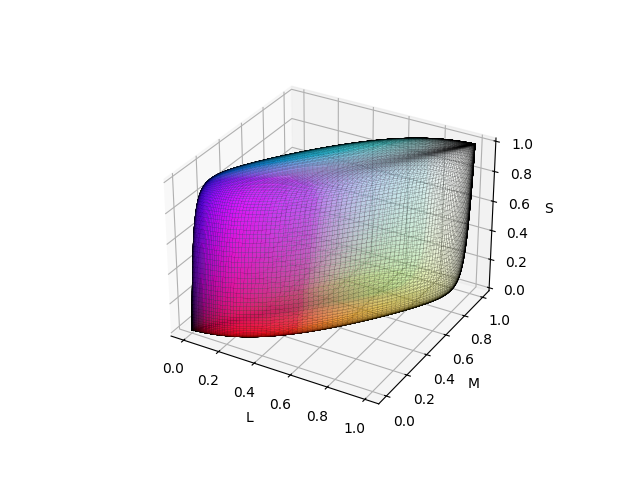

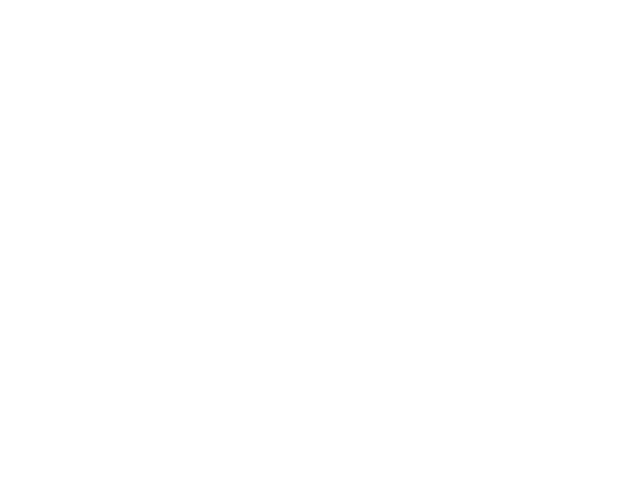

In [6]:
wavelengths = np.arange(395, 731, 2)
standard_tetrachromat = Observer.tetrachromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)
lqm = ObjectColorSolidAlpha2(standard_tetrachromat, illuminant, wavelengths, alpha='Q')
lqm.plot3DColorSolid(title='Object Color Solid (Alpha = Q Response)', xlabel='L', ylabel='M', zlabel='S')
plt.savefig('color_solid_Q_as_Alpha.png')  # Save the plot